In [1]:
import sys
sys.path.extend([
    '../../openml-python-OpenMLActiveClassificationTask/',
    '../../openml-scikit-activeml/'
])
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn import ensemble
from openml.tasks import OpenMLActiveClassificationTask, TaskType
from openml import tasks, runs
from skactiveml.classifier import ParzenWindowClassifier
from skactiveml.pool import UncertaintySampling, RandomSampling, ProbabilisticAL
import openml
import openml_skactiveml
from openml_skactiveml import PoolSkactivemlModel
openml.config.start_using_configuration_for_example()

/home/marek/Projects/GitHub/openml-skactiveml/openml-scikit-activeml/test_notebooks/../../openml-python-OpenMLActiveClassificationTask/openml/config.py:184: UserWarning: Switching to the test server https://test.openml.org/api/v1/xml to not upload results to the live server. Using the test server may result in reduced performance of the API!
  warnings.warn(


In [3]:
task_id = 5199
# task_id = 6175
task = tasks.get_task(task_id, download_data=False)

In [4]:
task

OpenML Active Classification Task
Task Type Description: https://test.openml.org/tt/TaskType.ACTIVE_CLASSIFICATION
Task ID..............: 5199
Task URL.............: https://test.openml.org/t/5199
Estimation Procedure.: crossvalidation
Evaluation Measure...: predictive_accuracy
Target Feature.......: class
# of Classes.........: 3
Cost Matrix..........: Available

In [5]:
# # # Example on how an AL task can be created from an existing classification task

# task_id = 1196
# task = tasks.get_task(task_id)

# my_task = openml.tasks.create_task(
#     task_type=TaskType.SUPERVISED_CLASSIFICATION,
#     dataset_id=128,
#     target_name="class",
#     evaluation_measure="predictive_accuracy",
#     estimation_procedure_id=1,
# )

# task = OpenMLActiveClassificationTask(
#         task_type_id=TaskType.ACTIVE_CLASSIFICATION,
#         task_type="ACTIVE_CLASSIFICATION",
#         data_set_id=task.dataset_id,
#         target_name=task.target_name,
#         class_labels=task.class_labels,
#         evaluation_measure="predictive_accuracy",
#         estimation_procedure_id=33, # 10-fold cross validation
#         # annotation_costs=np.arange(150, dtype=float)*0+1, # hard-coded annotation cost for now
#         batch_size=1,
#     )

# task.publish()

In [ ]:
# model = {
#     'query_strategy':UncertaintySampling(missing_label=None),
#     'prediction_model':ParzenWindowClassifier(missing_label=None, classes=task.class_labels),
#     'query_params':{
#         "clf": ParzenWindowClassifier(missing_label=None, classes=task.class_labels)
#     },
#     'budget': 100000,
# }

model = PoolSkactivemlModel(
    query_strategy=ProbabilisticAL(missing_label=None),
    prediction_model=ParzenWindowClassifier(missing_label=None, classes=task.class_labels),
    query_params={
        "clf": ParzenWindowClassifier(missing_label=None, classes=task.class_labels)
    },
    budget=100000,
)
# Automatically evaluate your model on the task
run = runs.run_model_on_task(model, task, upload_flow=False, avoid_duplicate_runs=False, n_jobs=1, seed=0)

In [50]:
run.publish()

OpenMLServerError: Unexpected server error when calling https://test.openml.org/api/v1/xml/flow/. Please contact the developers!
Status code: 500


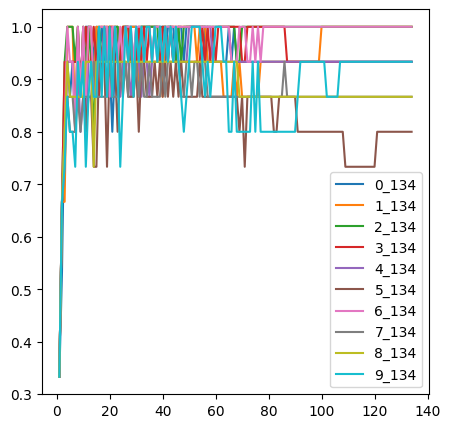

In [8]:
import matplotlib.pyplot as plt

X, y = task.get_X_and_y()

learning_curve_per_fold = []
budgets_per_fold = []

for repetition in range(1):
    for fold in range(10):
        fold_learning_curve = []
        preds = run.fold_evaluations['pred_t'][0][fold]
        budgets = run.fold_evaluations['budget_t'][0][fold]
        y_true_idx = task.get_train_test_split_indices(repeat=repetition, fold=fold)[1]
        y_true = np.array(task.class_labels)[y[y_true_idx]]
        for c in range(preds.shape[0]):
            fold_learning_curve.append(np.mean(preds[c,:] == y_true))
        learning_curve_per_fold.append(fold_learning_curve)
        budgets_per_fold.append(budgets)

for repetition in range(1):
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    fig.set_facecolor('w')
    for fold in range(10):
        plt.plot(budgets_per_fold[fold] , learning_curve_per_fold[fold], label=f"{fold}_{len(learning_curve_per_fold[fold])}")
    # plt.plot(np.mean(learning_curve_per_fold, axis=0), label=str(fold))
    plt.legend()
    display(fig)
    plt.close(fig)

In [ ]:
for budgets in [budgets_per_fold[0]]:
    plt.plot(budgets)

In [ ]:
import arff
test_export = arff.dumps(run._generate_arff_dict())
with open('test_export.arff', 'w') as f:
    f.write(test_export)

In [ ]:
run.to_filesystem('test_export')

In [10]:
import sklearn
import sklearn.impute
from sklearn.impute import SimpleImputer
from sklearn import ensemble
from openml import tasks, runs
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

# Build any model you like
# clf = ensemble.AdaBoostClassifier(estimator=DecisionTreeClassifier())
# clf = sklearn.pipeline.Pipeline(imputer=SimpleImputer(),classifier=DecisionTreeClassifier())

clf = ensemble.RandomForestClassifier()

# Download any OpenML task (includes the datasets)
task = tasks.get_task(119)



# Automatically evaluate your model on the task
run = runs.run_model_on_task(clf, task, upload_flow=False, avoid_duplicate_runs=False, n_jobs=1, seed=10)

# Share the results on OpenML.
# run.publish()

In [11]:
run.publish()

OpenMLServerException: https://test.openml.org/api/v1/xml/run/ returned code 201: Please provide run xml - Filesize is 0 bytes, which is not allowed.

In [7]:
run.flow.publish()

OpenML Flow
Flow ID.........: 84806 (version 21)
Flow URL........: https://test.openml.org/f/84806
Flow Name.......: sklearn.ensemble._forest.RandomForestClassifier
Flow Description: A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.
Upload Date.....: 2023-03-14 00:05:16
Dependencies....: sklearn==1.2.2
numpy>=1.17.3
scipy>=1.3.2
joblib>=1.1.1
threadpoolctl>=2.0.0

In [25]:
from sklearn.base import BaseEstimator
from collections import defaultdict



class PoolSkactivemlModel2():
    def __init__(self, query_strategy, prediction_model, query_params, budget):
        self.query_strategy = query_strategy
        self.prediction_model = prediction_model
        self.query_params = query_params
        self.budget = budget
    
    def get_params(self, deep=True):
        params_dict = {
                "query_params": self.query_params,
                "budget": self.budget,
                "query_strategy":self.query_strategy,
                "prediction_model":self.prediction_model
            }
        if deep:
            params_dict_qs = self.query_strategy.get_params()
            for k, v in params_dict_qs.items():
                params_dict[f'query_strategy__{k}'] = v
            params_dict_pm = self.prediction_model.get_params()
            for k, v in params_dict_pm.items():
                params_dict[f'prediction_model__{k}'] = v
            for k, v in self.query_params.items():
                params_dict[f'query_params+{k}'] = v
                if hasattr(v, "get_params"):
                    for k_sub, v_sub in v.get_params().items():
                        params_dict[f'query_params+{k}__{k_sub}'] = v_sub
        return params_dict

    def set_params(self, **params):
        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params(deep=True)

        nested_params = defaultdict(dict)  # grouped by prefix
        for key, value in params.items():
            key = key.replace("+", "__")
            key, delim, sub_key = key.partition("__")
            if key not in valid_params:
                local_valid_params = ["query_params", "budget", "query_strategy", "prediction_model"]
                raise ValueError(
                    f"Invalid parameter {key!r} for estimator {self}. "
                    f"Valid parameters are: {local_valid_params!r}."
                )
            if delim:
                nested_params[key][sub_key] = value
            else:
                setattr(self, key, value)
                valid_params[key] = value

        for key, sub_params in nested_params.items():
            if key == "query_params":
                query_nested_params = defaultdict(dict)  # grouped by prefix
                key, delim, sub_key = key.partition("__")
                if delim:
                    query_nested_params[key][sub_key] = value
                else:
                    setattr(self, key, value)
                    valid_params[key] = value
            else:
                valid_params[key].set_params(**sub_params)




        nested_params = defaultdict(dict)  # grouped by prefix
        for key, value in params.items():
            key, delim, sub_key = key.partition("__")
            if key not in valid_params:
                local_valid_params = BaseEstimator._get_param_names()
                raise ValueError(
                    f"Invalid parameter {key!r} for estimator {self}. "
                    f"Valid parameters are: {local_valid_params!r}."
                )

            if delim:
                nested_params[key][sub_key] = value
            else:
                setattr(self, key, value)
                valid_params[key] = value

        for key, sub_params in nested_params.items():
            valid_params[key].set_params(**sub_params)

        return self

In [43]:
from sklearn.ensemble import BaggingClassifier
from skactiveml.pool import UncertaintySampling
qs = UncertaintySampling()
clf = BaggingClassifier(ParzenWindowClassifier())
obj = PoolSkactivemlModel(query_strategy=qs, prediction_model=clf, query_params={'clf': clf}, budget=5)
obj.set_params(query_params__cost_matrix=None)
d1 = obj.get_params()
print(d1)

AttributeError: 'dict' object has no attribute 'set_params'

In [27]:
obj2 = PoolSkactivemlModel2(query_strategy=qs, prediction_model=clf, query_params={'clf': clf}, budget=5)
d2 = obj2.get_params()
d2

{'query_params': {'clf': BaggingClassifier(estimator=ParzenWindowClassifier())},
 'budget': 5,
 'query_strategy': UncertaintySampling(),
 'prediction_model': BaggingClassifier(estimator=ParzenWindowClassifier()),
 'query_strategy__cost_matrix': None,
 'query_strategy__method': 'least_confident',
 'query_strategy__missing_label': nan,
 'query_strategy__random_state': None,
 'prediction_model__base_estimator': 'deprecated',
 'prediction_model__bootstrap': True,
 'prediction_model__bootstrap_features': False,
 'prediction_model__estimator__class_prior': 0.0,
 'prediction_model__estimator__classes': None,
 'prediction_model__estimator__cost_matrix': None,
 'prediction_model__estimator__metric': 'rbf',
 'prediction_model__estimator__metric_dict': None,
 'prediction_model__estimator__missing_label': nan,
 'prediction_model__estimator__n_neighbors': None,
 'prediction_model__estimator__random_state': None,
 'prediction_model__estimator': ParzenWindowClassifier(),
 'prediction_model__max_featu

In [18]:
for k, v in d1.items():
    print(f"{k}: {v == d2[k]}")

budget: True
prediction_model__base_estimator: True
prediction_model__bootstrap: True
prediction_model__bootstrap_features: True
prediction_model__estimator__class_prior: True
prediction_model__estimator__classes: True
prediction_model__estimator__cost_matrix: True
prediction_model__estimator__metric: True
prediction_model__estimator__metric_dict: True
prediction_model__estimator__missing_label: False
prediction_model__estimator__n_neighbors: True
prediction_model__estimator__random_state: True
prediction_model__estimator: True
prediction_model__max_features: True
prediction_model__max_samples: True
prediction_model__n_estimators: True
prediction_model__n_jobs: True
prediction_model__oob_score: True
prediction_model__random_state: True
prediction_model__verbose: True
prediction_model__warm_start: True
prediction_model: True
query_params: True
query_strategy__cost_matrix: True
query_strategy__method: True
query_strategy__missing_label: False
query_strategy__random_state: True
query_stra

In [143]:
{'a':1,'b':1}=={'a':1,'b':1}

True

In [82]:
obj = PoolSkactivemlModel(1,2,3,4)
isinstance(obj, sklearn.base.BaseEstimator)
# issubclass(PoolSkactivemlModel, PoolSkactivemlModel)

True

In [53]:
PoolSkactivemlModel.__bases__
obj.__bases__

In [54]:
PoolSkactivemlModel.__bases__

(sklearn.base.BaseEstimator,)

In [56]:
from sklearn.base import BaseEstimator

class PoolSkactivemlModel():
        def __init__(self, query_strategy, prediction_model, query_params, budget):
            self.query_strategy = query_strategy
            self.prediction_model = prediction_model
            self.query_params = query_params
            self.budget = budget

def _wrap_skactiveml_model(clf, model):
    class PoolSkactivemlModel(BaseEstimator):
        def __init__(self, query_strategy, prediction_model, query_params, budget):
            self.query_strategy = query_strategy
            self.prediction_model = prediction_model
            self.query_params = query_params
            self.budget = budget

    return PoolSkactivemlModel(
        query_strategy=model.query_strategy,
        prediction_model=model.prediction_model,
        query_params=model.query_params,
        budget=model.budget,
    )

obj = PoolSkactivemlModel(query_strategy=qs, prediction_model=clf, query_params={'clf': clf}, budget=5)
print(isinstance(obj, BaseEstimator))
obj_new = _wrap_skactiveml_model(_, obj)
print(isinstance(obj_new, BaseEstimator))
print(obj_new)

False
True
PoolSkactivemlModel(budget=5,
                    prediction_model=BaggingClassifier(estimator=ParzenWindowClassifier()),
                    query_params={'clf': BaggingClassifier(estimator=ParzenWindowClassifier())},
                    query_strategy=UncertaintySampling())


In [58]:
obj.get_params()

AttributeError: 'PoolSkactivemlModel' object has no attribute 'get_params'